In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import folium
import seaborn as sns

sns.set()

In [2]:
LOCATION = 'munich'

df_list = pd.read_csv(LOCATION + '/listings.csv.gz')
df_reviews = pd.read_csv(LOCATION + '/reviews.csv.gz')
df_cal = pd.read_csv(LOCATION + '/calendar.csv.gz')

df_list_sum = pd.read_csv(LOCATION + '/listings.csv')
df_reviews_sum = pd.read_csv(LOCATION + '/reviews.csv')
df_neib_sum = pd.read_csv(LOCATION + '/neighbourhoods.csv')

df_list_orig = df_list.copy()

In [3]:
pd.options.display.max_rows=100
pd.options.display.max_columns=None
pd.options.display.max_colwidth=30

---

### Check data types, especially for the **price** column.

In [4]:
df_list.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
description                                      object
neighborhood_overview                            object
picture_url                                      object
host_id                                           int64
host_url                                         object
host_name                                        object
host_since                                       object
host_location                                    object
host_about                                       object
host_response_time                               object
host_response_rate                               object
host_acceptance_rate                             object
host_is_superhost                               

#### Convert **price** to float

In [5]:
df_list['price']=df_list['price'].replace(to_replace='[\$,]', value='', regex=True).astype(float)

___

### Checking missing values and outliers in the prices:

Check NULL values first:

In [6]:
str(round(len(df_list[df_list['price'].isnull()])/df_list.shape[0]*100, ndigits=2)) + ' %'

'0.0 %'

Cool, no NULLs.

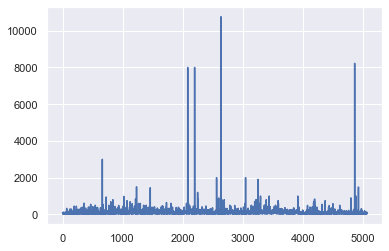

In [7]:
df_list['price'].plot();

### What is the distribution on prices:

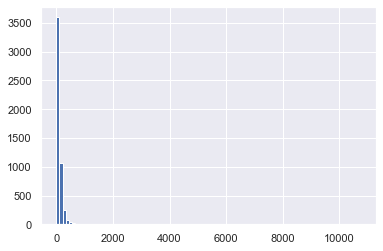

In [8]:
ax=df_list['price'].hist(bins=100);

#### Zoom in to 0-800

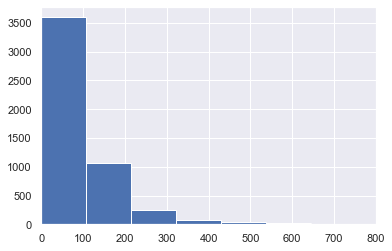

In [9]:
ax=df_list['price'].hist(bins=100);
ax.set_xlim(left=0, right=800);

### Prices above $500 are outliers, let's remove them before starting the analysis

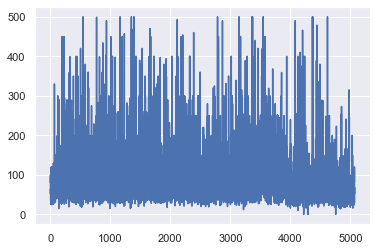

In [10]:
df_list = df_list[df_list['price']<=500]
df_list['price'].plot();

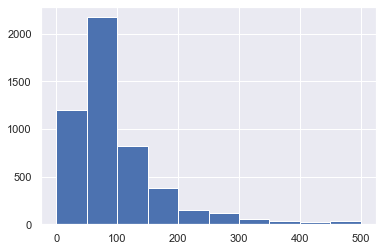

In [11]:
df_list['price'].hist();

___

### Checking missing values and outliers in the ratings:

Before we start, let's check NULL values

In [12]:
str(round(len(df_list[df_list['review_scores_rating'].isnull()])/df_list.shape[0]*100, ndigits=2)) + ' %'

'26.21 %'

Replace this NULL values by the mean of listings **in the same location** (neighbourhood_cleansed).

Calculate average rating of listings per location (neighbourhood_cleansed) and add it as new column to the listings:

In [13]:
avg_ratings = df_list[['neighbourhood_cleansed', 'review_scores_rating']].groupby(by='neighbourhood_cleansed').mean().reset_index()
avg_ratings = avg_ratings.rename(columns={"review_scores_rating": "avg_location_rating", "neighbourhood_cleansed":"location"})
df_list = pd.merge(df_list, avg_ratings, how='inner', left_on='neighbourhood_cleansed', right_on='location').drop(columns=['location'])

Fill NaN using the average location rating value:

In [14]:
df_list['review_scores_rating'] = df_list['review_scores_rating'].fillna(value=df_list['avg_location_rating'])

Check NULL values again:

In [15]:
str(round(len(df_list[df_list['review_scores_rating'].isnull()])/df_list.shape[0]*100, ndigits=2)) + ' %'

'0.0 %'

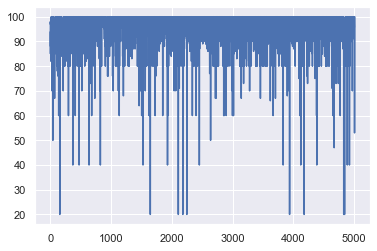

In [16]:
df_list['review_scores_rating'].plot();

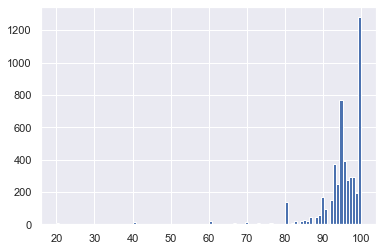

In [17]:
df_list['review_scores_rating'].hist(bins=100);

### It looks like all ratings below 80 are outlier. 
### They should be remove before we start to calculate average rating per location to not to negatively bias the whole location!

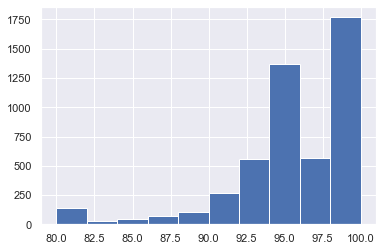

In [18]:
df_list = df_list[df_list['review_scores_rating']>=80]
df_list['review_scores_rating'].hist();

**Looks better now!**

-----

## Let's have a look at prices per location:

### Calculate average price for each location (neighbourhood_cleansed)

In [19]:
avg_prices = df_list[['neighbourhood_cleansed', 'price']].groupby(by='neighbourhood_cleansed').mean().reset_index()
avg_prices = avg_prices.rename(columns={"neighbourhood_cleansed":"location", "price": "avg_location_price"})

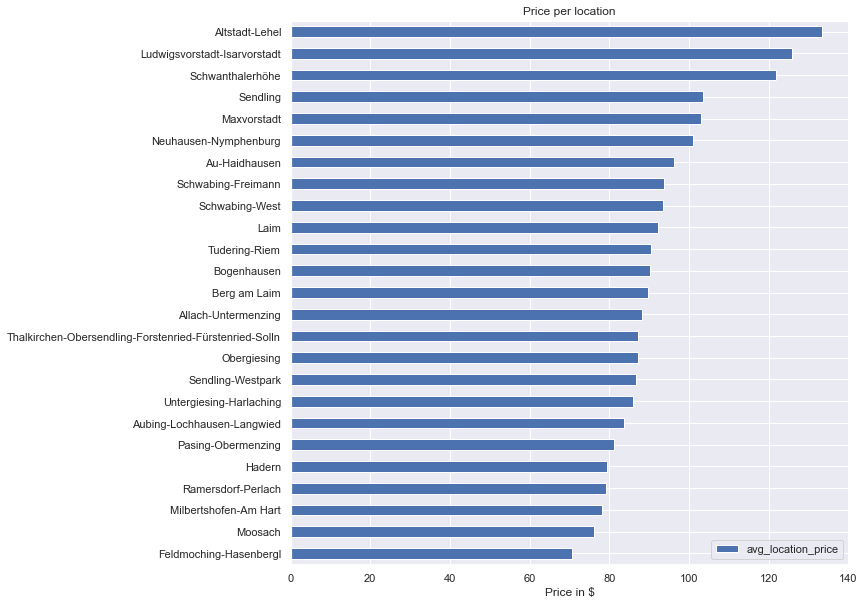

In [20]:
avg_prices.sort_values(by='avg_location_price', ascending=True).plot.barh(x='location', y='avg_location_price', figsize=(10,10));
ax = plt.gca()
ax.set_title('Price per location');
ax.set_ylabel('')
ax.set_xlabel('Price in $');

### Ploting geographical distribution of prices per city location:

In [21]:
df_list = pd.merge(df_list, avg_prices, how='inner', left_on='neighbourhood_cleansed', right_on='location').drop(columns='location')

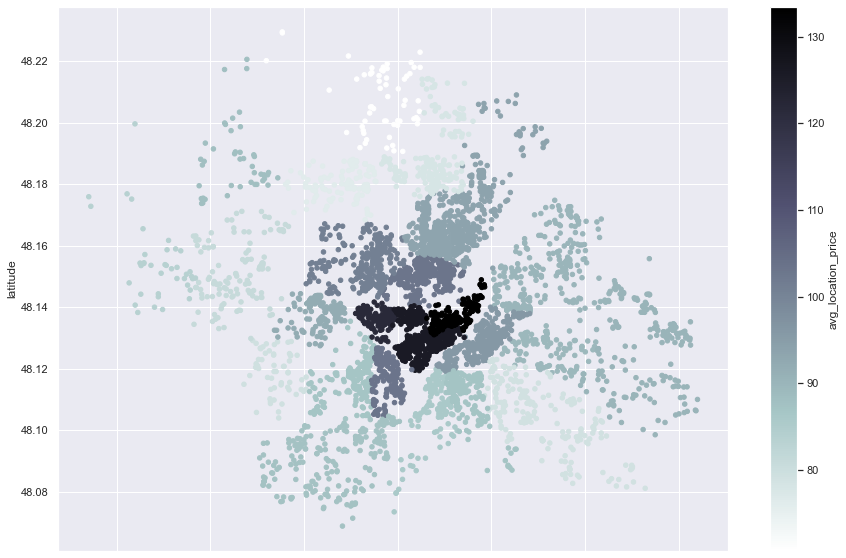

In [22]:
#sns.set(rc={'axes.facecolor':'#8a8e91'})
df_list.plot(kind='scatter', x='longitude', y='latitude', alpha=1, c='avg_location_price', figsize=(15,10), cmap=plt.get_cmap('bone_r'));

---

## Comparing prices and ratings
### Ploting geographical distribution of ratings per city location:

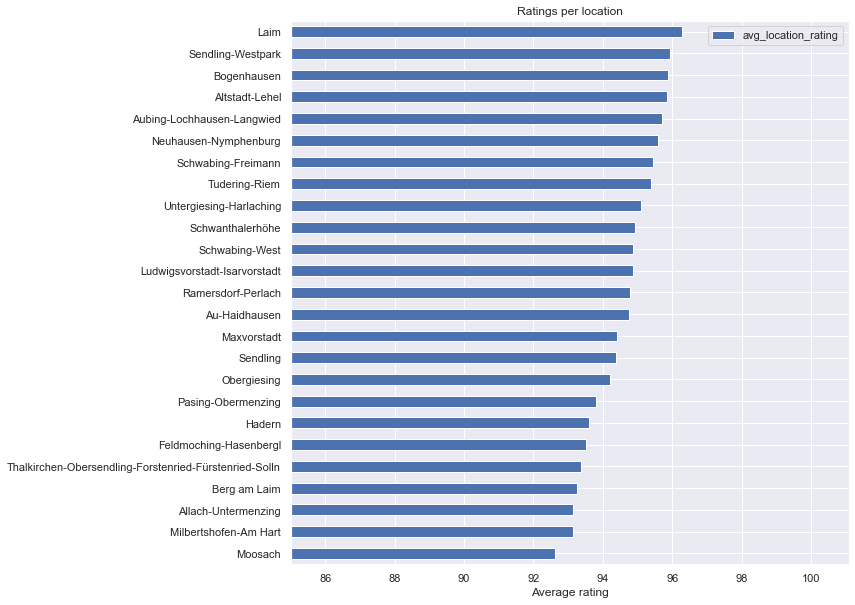

In [23]:
avg_ratings.sort_values(by='avg_location_rating', ascending=True).plot.barh(x='location', y='avg_location_rating', figsize=(10,10));
ax = plt.gca()
ax.set_title('Ratings per location');
ax.set_ylabel('')
ax.set_xlabel('Average rating');
ax.set_xlim(left=85);

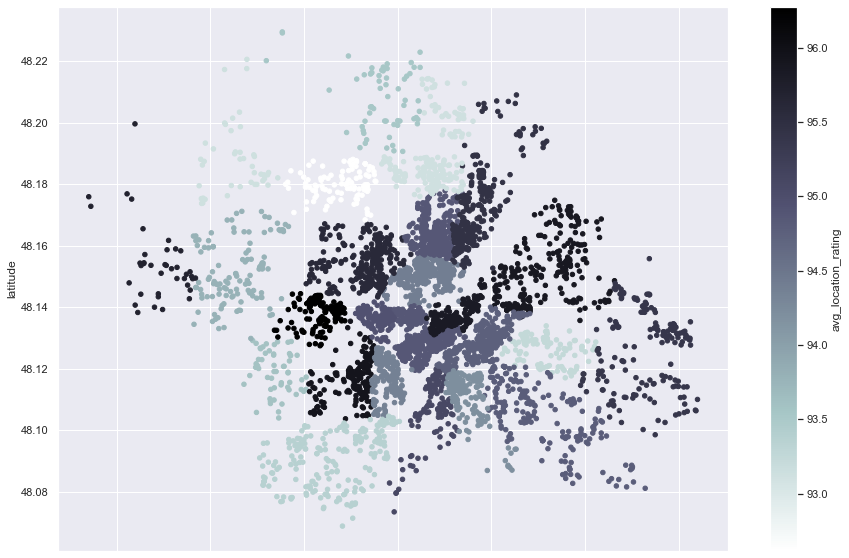

In [24]:
df_list.plot(kind='scatter', x='longitude', y='latitude', alpha=1, c='avg_location_rating', figsize=(15,10), cmap=plt.get_cmap('bone_r'));

### There is no clear correlation between price and location. The best rated locations are around the centre but not too far from centre. Locations in the middle of the city are the most expensive which can have negative impact on ratings.

---

## Are best rated accomodations the ones which are booked out (the least available)?
### Ploting geographical distribution of availabillity (365) per city location:

In [25]:
avg_avail_365 = df_list[['neighbourhood_cleansed', 'availability_365']].groupby(by='neighbourhood_cleansed').mean().reset_index()
avg_avail_365 = avg_avail_365.rename(columns={"neighbourhood_cleansed":"location", "availability_365": "avg_location_avail_365"})
df_list = pd.merge(df_list, avg_avail_365, how='inner', left_on='neighbourhood_cleansed', right_on='location').drop(columns='location')

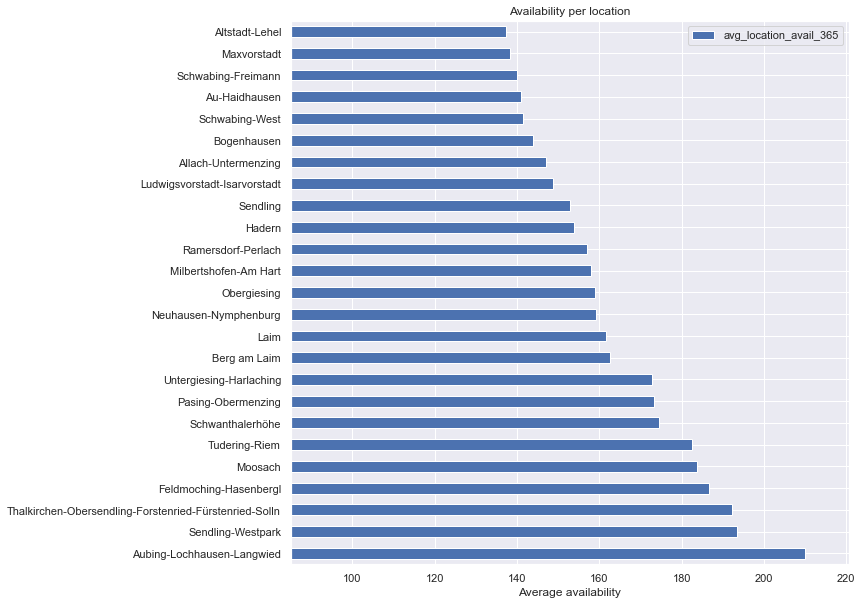

In [26]:
avg_avail_365.sort_values(by='avg_location_avail_365', ascending=False).plot.barh(x='location', y='avg_location_avail_365', figsize=(10,10));
ax = plt.gca()
ax.set_title('Availability per location');
ax.set_ylabel('')
ax.set_xlabel('Average availability');
ax.set_xlim(left=85);

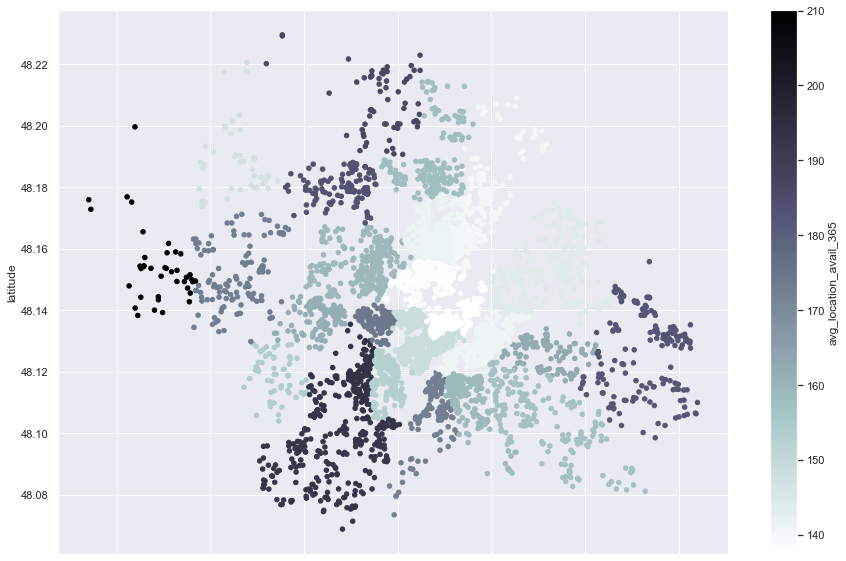

In [27]:
df_list.plot(kind='scatter', x='longitude', y='latitude', alpha=1, c='avg_location_avail_365', figsize=(15,10), cmap=plt.get_cmap('bone_r'));

### Locations with lower rating have higher availability (over the year). Especialy is this visible on the vertical axe through the centre of the city (south --> mid --> north). This might be showing a tendence where guests pick there accomodation based on the ratings.

But...there are some exceptions: Sendling-Westpark ist good rated location but still having a lot of available accomodations.

# **IMPORTANT REMARK**: 
## The whole availability data might be biased due to the Covid-19 lockdown. The listings might not really be available, even if not booked.

---------------------------

# We have found good locations to book. Let's see what property type is reasonable regarding the cost.
## Let's check property types before answering the question

Drop price==0

In [28]:
len(df_list[df_list['price']==0])

4

In [29]:
df_list = df_list[df_list['price']>0].copy()

___

### Let's focus to most common property types (top 20 in ranking of common property types)

In [30]:
df_list['property_type'].value_counts()[:20]

Entire apartment                      2372
Private room in apartment             1469
Private room in house                  178
Room in hotel                          127
Entire serviced apartment              127
Entire condominium                      85
Entire loft                             76
Shared room in apartment                60
Room in boutique hotel                  54
Private room in townhouse               48
Private room in condominium             48
Private room in serviced apartment      39
Entire house                            35
Private room in hostel                  27
Room in serviced apartment              19
Private room in loft                    15
Private room in bed and breakfast       14
Room in aparthotel                      13
Entire townhouse                        10
Entire guest suite                      10
Name: property_type, dtype: int64

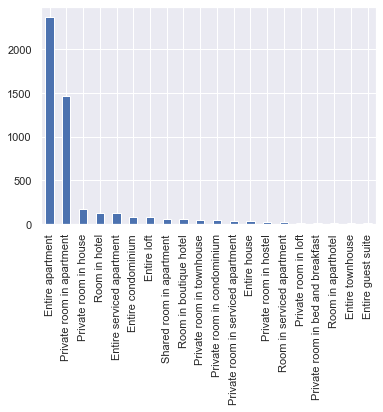

In [31]:
df_list['property_type'].value_counts()[:20].plot(kind='bar');

In [32]:
top20=df_list['property_type'].value_counts()[:20]

In [33]:
lst_top20 = list(top20.index)

In [34]:
df_list_top_20 = df_list[df_list['property_type'].isin(lst_top20)].copy()

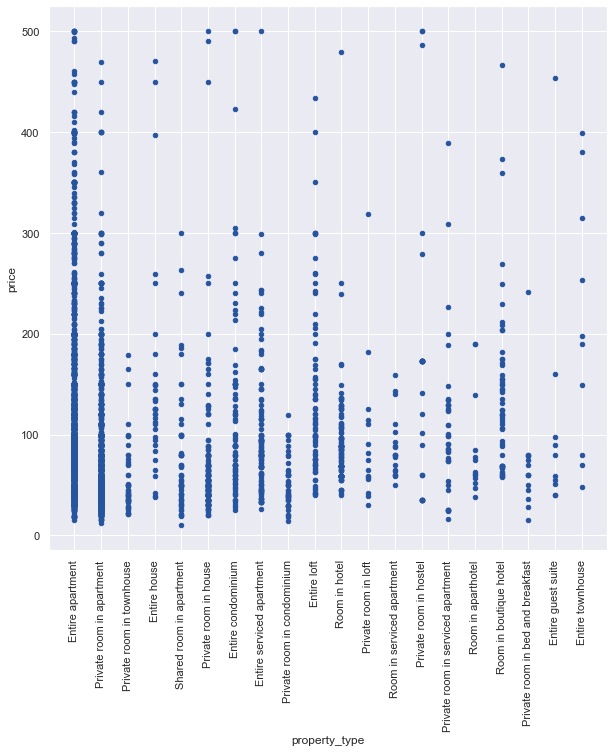

In [35]:
df_list_top_20.plot(kind='scatter', x='property_type', y='price', rot=90,  figsize=(10,10), c='#26549e');


### Ok, this doesn't provide much value. You can find each property type with huge variance in price. 
### Instead of this ^^ let's have a look what property types are good compared to average price of all property types **in the same location**. This can releave reasonable property types (not too expensive)

---

### First, let's calculate the diff between each listing and the average price of the location this listing is in. Let's calculate absolute and relative difference (%).

In [36]:
df_list_top_20['avg_price_diff'] = df_list_top_20['price'] - df_list_top_20['avg_location_price']
df_list_top_20['avg_price_diff_perc'] = np.round(100*((df_list_top_20['price']-df_list_top_20['avg_location_price'])/df_list_top_20['price']), decimals=2)
df_list_top_20[['property_type','price', 'avg_location_price', 'avg_price_diff', 'avg_price_diff_perc']]

,property_type,price,avg_location_price,avg_price_diff,avg_price_diff_perc
0,Entire apartment,80.0,79.368421,0.631579,0.79
1,Private room in apartment,46.0,79.368421,-33.368421,-72.54
2,Entire apartment,80.0,79.368421,0.631579,0.79
3,Private room in townhouse,99.0,79.368421,19.631579,19.83
4,Entire house,39.0,79.368421,-40.368421,-103.51
...,...,...,...,...,...
4906,Private room in house,23.0,83.717949,-60.717949,-263.99
4907,Private room in condominium,50.0,83.717949,-33.717949,-67.44
4908,Private room in serviced a...,45.0,83.717949,-38.717949,-86.04
4909,Private room in house,20.0,83.717949,-63.717949,-318.59


### Now, let's group all listings by property type and calculate the average diff per property:

In [37]:
avg_prices_loc_prop = np.round(df_list_top_20[['property_type', 'avg_price_diff_perc']].groupby(by=['property_type']).mean(), decimals=2).reset_index()
sorted_top20 = avg_prices_loc_prop.sort_values(by='avg_price_diff_perc', ascending=False).set_index('property_type')

In [38]:
sorted_top20.style.bar(subset=['avg_price_diff_perc'], align='mid', color=['#fcc9b8', '#86eba0'], width=100)

,avg_price_diff_perc
property_type,
Entire townhouse,34.760000
Entire house,18.040000
Room in boutique hotel,4.050000
Entire loft,2.650000
Room in serviced apartment,-6.730000
Private room in hostel,-17.540000
Entire condominium,-18.330000
Entire apartment,-22.240000
Room in hotel,-30.500000


### Here we are: We see, what property types we should consider looking at our budget.

---

# Summary:

### If you want to get a reasonable accomodation in Munich based on rating and price, try to pick something around the centre of the city. You will not pay too much and will get best rated accomodations.
### To optimize your costs, a private room in a condo or in a townhouse might be a good choice. (If money is not your problem, a house or a townhouse is an alternative).